[tutorial](https://www.learnopencv.com/faster-r-cnn-object-detection-with-pytorch/)

[tutorial](https://pytorch.org/docs/stable/torchvision/models.html#torchvision.models.detection.fasterrcnn_resnet50_fpn) 

In [1]:
%load_ext lab_black

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import torch
import torchvision
from torchvision import transforms

In [3]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# fmt: off
model.eval();
# fmt: on

In [4]:
# fmt: off
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
# fmt: on

In [5]:
def get_prediction(img, threshold):

    transform = transforms.Compose([transforms.ToTensor()])  # Defing PyTorch Transform
    img = transform(img)  # Apply the transform to the image
    pred = model(img.unsqueeze(0))  # Pass the image to the model
    pred_class = [
        COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]["labels"].numpy())
    ]  # Get the Prediction Score
    # [(x, y), (width, height)] matplotlib format
    pred_boxes = [
        [(i[0], i[1]), (i[2] - i[0], i[3] - i[1])]
        for i in list(pred[0]["boxes"].detach().numpy())
    ]  # Bounding boxes
    pred_score = list(pred[0]["scores"].detach().numpy())
    # fmt: off
    # Get list of index with score greater than threshold.
    pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]  
    # fmt: on
    pred_boxes = pred_boxes[: pred_t + 1]
    pred_class = pred_class[: pred_t + 1]
    return pred_boxes, pred_class

In [6]:
def object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
    img = Image.open(img_path)  # Load the image
    boxes, pred_cls = get_prediction(img, threshold)  # Get predictions
    fig, ax = plt.subplots(1, figsize=(15, 7))
    ax.imshow(img)
    for box, label in zip(boxes, pred_cls):
        rect = patches.Rectangle(
            box[0], *box[1], linewidth=1, edgecolor="r", facecolor="none",
        )
        ax.add_patch(rect)
        ax.text(
            *box[0],
            label,
            fontsize=12,
            color="white",
            bbox=dict(facecolor="r", alpha=0.8, pad=0.2, ec="none"),
        )
    plt.axis("off")
    plt.show()

/home/jack/anaconda3/envs/onnx/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


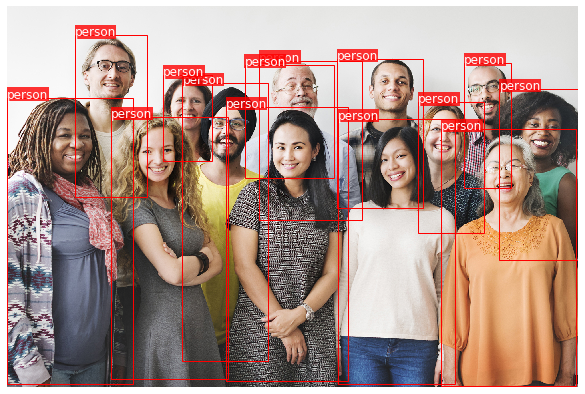

In [7]:
object_detection_api("people.jpg")

In [8]:
img = Image.open("people.jpg")

transform = transforms.Compose([transforms.ToTensor()])  # Defing PyTorch Transform
x = transform(img).unsqueeze(0)

In [9]:
# Input to the model
torch_out = model(x)

In [10]:
# Export the model
torch.onnx.export(
    model,  # model being run
    x,  # model input (or a tuple for multiple inputs)
    "faster-rcnn.onnx",  # where to save the model (can be a file or file-like object)
    export_params=True,  # store the trained parameter weights inside the model file
    opset_version=11,  # faster only works with 11. 
    do_constant_folding=True,  # whether to execute constant folding for optimization
    input_names=["input"],  # the model's input names
    output_names=["output"],  # the model's output names
)

/home/jack/anaconda3/envs/onnx/lib/python3.7/site-packages/torch/tensor.py:467: RuntimeWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  'incorrect results).', category=RuntimeWarning)
/opt/conda/conda-bld/pytorch_1587428398394/work/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.
/home/jack/anaconda3/envs/onnx/lib/python3.7/site-packages/torchvision/models/detection/rpn.py:164: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(image_size[1] / g[1], dtype=torch.int64, device=d

## Loading ONNX Model

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import onnxruntime

# fmt: off
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
# fmt: on


def get_image(image_path):
    img = Image.open(image_path)
    img.readonly = False  # https://github.com/python-pillow/Pillow/issues/3336
    # onnx only works with numpy. and values range from 0-1
    img = np.asarray(img) / 255
    img = img.transpose((2, 0, 1))[None, :, :, :]  # add batchsize of 1
    return img.astype("float32")  # onnx only works with 4bits


def process_prediction(pred, threshold):
    pred_class = [
        COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[1])
    ]  # Get the Prediction Score
    # [(x, y), (width, height)] matplotlib format
    pred_boxes = [
        [(i[0], i[1]), (i[2] - i[0], i[3] - i[1])] for i in list(pred[0])
    ]  # Bounding boxes
    pred_score = list(pred[2])
    # fmt: off
    # Get list of index with score greater than threshold.
    pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]  
    # fmt: on
    pred_boxes = pred_boxes[: pred_t + 1]
    pred_class = pred_class[: pred_t + 1]
    return pred_boxes, pred_class


def object_detection_api(img_path, pred, threshold=0.5):
    img = Image.open(img_path)  # Load the image
    boxes, pred_cls = process_prediction(pred, threshold)  # Get predictions
    fig, ax = plt.subplots(1, figsize=(15, 7))
    ax.imshow(img)
    for box, label in zip(boxes, pred_cls):
        rect = patches.Rectangle(
            box[0], *box[1], linewidth=1, edgecolor="r", facecolor="none",
        )
        ax.add_patch(rect)
        ax.text(
            *box[0],
            label,
            fontsize=12,
            color="white",
            bbox=dict(facecolor="r", alpha=0.8, pad=0.2, ec="none"),
        )
    plt.axis("off")
    plt.show()

In [4]:
ort_session = onnxruntime.InferenceSession("faster-rcnn.onnx")

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: get_image("people.jpg")}
ort_outs = ort_session.run(None, ort_inputs)
ort_outs

[array([[0.0000000e+00, 3.1964536e+02, 4.4151535e+02, 1.3232561e+03],
        [7.6530365e+02, 3.5194049e+02, 1.1937161e+03, 1.3122842e+03],
        [1.1569447e+03, 3.9462311e+02, 1.5692056e+03, 1.3221746e+03],
        [1.5193402e+03, 4.2956503e+02, 1.9924286e+03, 1.3306053e+03],
        [3.6410751e+02, 3.8761441e+02, 7.7179010e+02, 1.3061730e+03],
        [6.1342780e+02, 2.6801114e+02, 9.1221960e+02, 1.2417460e+03],
        [1.4390378e+03, 3.3610452e+02, 1.6699921e+03, 7.9422113e+02],
        [1.7239886e+03, 2.8932889e+02, 1.9978444e+03, 8.8991754e+02],
        [1.1548141e+03, 1.8347633e+02, 1.4561610e+03, 7.0533588e+02],
        [1.6002692e+03, 1.9745711e+02, 1.7637482e+03, 6.3540698e+02],
        [8.8222968e+02, 1.9024481e+02, 1.2439409e+03, 7.4671735e+02],
        [5.4619714e+02, 2.4166563e+02, 7.1724133e+02, 5.4152289e+02],
        [2.3673456e+02, 1.0111604e+02, 4.8953281e+02, 6.6732379e+02],
        [8.3153918e+02, 2.0396672e+02, 1.1440724e+03, 6.0038452e+02],
        [2.1523401e+

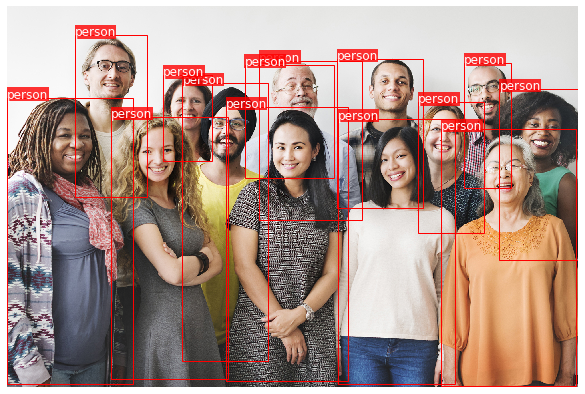

In [5]:
object_detection_api("people.jpg", ort_outs, 0.5)

In [6]:
tmp = get_image("people.jpg")

In [7]:
tmp.shape

(1, 3, 1333, 2000)